In [100]:
import copy 

import cv2  
import numpy as np
import open3d as o3d
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

def depth_to_point_cloud(depth_image, camera_intrinsics, depth_scale=1.0):
    """
    Convert a depth image into a point cloud.

    Parameters:
    - depth_image: np.ndarray, the depth image.
    - camera_intrinsics: o3d.camera.PinholeCameraIntrinsic, camera intrinsics.
    - depth_scale: float, the scale to convert depth image values to meters.

    Returns:
    - pcd: open3d.geometry.PointCloud, the converted point cloud.
    """
    # Create an Open3D depth image from the depth array
    depth_o3d = o3d.geometry.Image(depth_image.astype(np.uint16))
    
    # Create a point cloud from the depth image and camera intrinsics
    pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_o3d, camera_intrinsics, depth_scale=depth_scale)
    
    return pcd

def add_color_to_point_cloud(pcd, color_image):
    """
    Assign colors to the point cloud from a color image.

    Parameters:
    - pcd: open3d.geometry.PointCloud, the point cloud to colorize.
    - color_image: np.ndarray, the color (segmentation) image.

    Returns:
    - colored_pcd: open3d.geometry.PointCloud, the colored point cloud.
    """
    # Convert the color image to Open3D image
    color_o3d = o3d.geometry.Image(color_image)
    
    # Assign colors to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(np.asarray(color_o3d) / 255.0)  # Normalize colors
    
    return pcd

def create_rgbd_image_from_depth_and_rgb(depth_image_path, rgb_image_path, depth_scale=1000.0, depth_trunc=3.0):
    """
    Create an RGBD image from separate depth and RGB images.

    Parameters:
    - depth_image_path: str, the file path to the depth image.
    - rgb_image_path: str, the file path to the RGB image.
    - depth_scale: float, the scale to convert depth image values to meters.
    - depth_trunc: float, the maximum depth value to consider.

    Returns:
    - rgbd_image: open3d.geometry.RGBDImage, the created RGBD image.
    """
    # Load depth image
    depth_image = o3d.io.read_image(depth_image_path)
    # Load RGB image
    rgb_image = o3d.io.read_image(rgb_image_path)
    
    # Create an RGBD image
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgb_image, depth_image, depth_scale=depth_scale, depth_trunc=depth_trunc, convert_rgb_to_intensity=False)
    
    return rgbd_image

def create_point_cloud_from_rgbd(rgbd_image, camera_intrinsics):
    """
    Create a point cloud from an RGBD image.

    Parameters:
    - rgbd_image: open3d.geometry.RGBDImage, the RGBD image.
    - camera_intrinsics: o3d.camera.PinholeCameraIntrinsic, camera intrinsics.

    Returns:
    - pcd: open3d.geometry.PointCloud, the created point cloud.
    """
    # Create a point cloud from the RGBD image
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image, camera_intrinsics)
    
    return pcd

def align_vector_to_z_axis(vector):
    """
    Compute a rotation matrix that aligns the given vector to the z-axis.
    """
    # Target vector (z-axis)
    target = np.array([0, 0, 1])
    
    # Rotation axis (cross product between vector and target)
    axis = np.cross(vector, target)
    axis_length = np.linalg.norm(axis)
    if axis_length > 0:
        axis = axis / axis_length
    
    # Angle between vector and target
    angle = np.arccos(np.dot(vector, target) / (np.linalg.norm(vector) * np.linalg.norm(target)))
    
    # Rotation matrix around axis by angle
    if axis_length > 0:  # If not parallel
        rotation_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(axis * angle)
    else:
        rotation_matrix = np.eye(3)  # No rotation needed
    
    return rotation_matrix

def project_point_cloud(pcd, plane_normal):
    """
    Project a point cloud onto a plane defined by its normal vector by first aligning the plane with the horizontal plane.
    """
    # Normalize the plane normal vector
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    
    # Compute the rotation matrix to align the plane normal with the z-axis
    rotation_matrix = align_vector_to_z_axis(plane_normal)
    
    # Apply the rotation to the point cloud
    pcd = pcd.rotate(rotation_matrix, center=(0, 0, 0))
    
    # Project the rotated point cloud onto the horizontal plane by setting z to a constant
    # Here, we use 0 for simplicity. Adjust as needed.
    points = np.asarray(pcd.points)
    points[:, 2] = 0  # Set z-component to 0 (or to the desired height)
    pcd.points = o3d.utility.Vector3dVector(points)
    
    return pcd


In [83]:
pcd = o3d.io.read_point_cloud('../data/blainder_exports/blainder_tape_test_001_frames_1_to_1.ply')
print(f'{pcd=}')
o3d.visualization.draw_geometries([o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0), pcd])


pcd=PointCloud with 62434 points.


## Create colored point cloud from RGBD image

In [95]:
# Load depth image and segmentation (color) image
depth_image_path = '../data/blainder_exports/blainder_tape_test_001_frame_1_image_depthmap.png'
rgb_image_path = '../data/blainder_exports/blainder_tape_test_001_frame_1_image_segmented.png'

# Define camera intrinsics, replace with your actual camera parameters
# [[160.   0. 160.]
# [  0. 160. 120.]
# [  0.   0.   1.]]
camera_intrinsics = o3d.camera.PinholeCameraIntrinsic(width=320, height=240, fx=160, fy=220, cx=160, cy=120)

# Create RGBD image from depth and RGB images
rgbd_image = create_rgbd_image_from_depth_and_rgb(depth_image_path, rgb_image_path, depth_scale=10000)

# Create point cloud from RGBD image
pcd = create_point_cloud_from_rgbd(rgbd_image, camera_intrinsics)
print(f'{pcd=}')

# Visualize the point cloud
o3d.visualization.draw_geometries([o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1), pcd])

pcd=PointCloud with 62434 points.


## Filter point cloud by segmentation results

In [96]:
colors = np.asarray(pcd.colors)  # Get the colors of the points
colors *= 255

# Define a list of specific valid colors in RGB
valid_colors = [
    np.array([255, 0, 0]),  # Red
    # np.array([0, 255, 0]),  # Green
    np.array([0, 0, 255]),  # Blue
    np.array([69, 69, 125]) 
    # Add more specific colors as needed
]

# Initialize an array of False values to mark whether each point is valid
valid_indices = np.zeros(len(colors), dtype=bool)

# Check each point to see if its color matches any of the valid colors
for color in valid_colors:
    # Create a mask for points whose colors match the current valid color
    matches_color = np.all(np.isclose(colors, color), axis=1)
    # Combine with previous matches (logical OR)
    valid_indices = valid_indices | matches_color

# Select the points and colors that match the filter
filtered_points = np.asarray(pcd.points)[valid_indices]
filtered_colors = colors[valid_indices] / 255  # Rescale colors back to [0, 1]

# Create a new point cloud with the filtered points
filtered_pcd = o3d.geometry.PointCloud()
filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)
filtered_pcd.colors = o3d.utility.Vector3dVector(filtered_colors)
print(f'{filtered_pcd=}')


o3d.visualization.draw_geometries([o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1), filtered_pcd])

filtered_pcd=PointCloud with 2099 points.


## Transform point cloud into world coordinate frame

In [97]:
camera_rotation_euler_xyz_deg = [50.35, 0, 46.69]
camera_rotation_scipy = Rotation.from_euler(seq='xyz', angles=camera_rotation_euler_xyz_deg, degrees=True)
camera_rotation_matrix = camera_rotation_scipy.as_matrix()
# Create a 4x4 transformation matrix
transformation_matrix = np.eye(4)  # Initialize a 4x4 identity matrix
transformation_matrix[:3, :3] = camera_rotation_matrix  # Set the top-left 3x3 block to R
transformed_pcd = copy.copy(filtered_pcd).rotate(camera_rotation_matrix, center=(0, 0, 0))

# # Define an identity transformation (no rotation and no translation)
# transformation_matrix = np.array([
#     [1, 0, 0, 0],  # No rotation (identity matrix part)
#     [0, 1, 0, 0],
#     [0, 0, 1, 0],
#     [0, 0, 0, 1]   # No translation
# ])

# Apply the identity transformation to the point cloud
# transformed_pcd = copy.copy(pcd).transform(transformation_matrix)

# Visualize the transformed point cloud (should look unchanged in this case)
o3d.visualization.draw_geometries([o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1), transformed_pcd])

### Project onto LIDAR plane

In [98]:
# Assuming 'pcd' is your Open3D point cloud loaded or defined previously
plane_normal = np.array([0, 0, 1])  # Example plane normal vector

# Project the point cloud onto the plane
projected_pcd = project_point_cloud(transformed_pcd, plane_normal)

# Visualize the projected point cloud
o3d.visualization.draw_geometries([o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1), projected_pcd])

## Emulate LIDAR

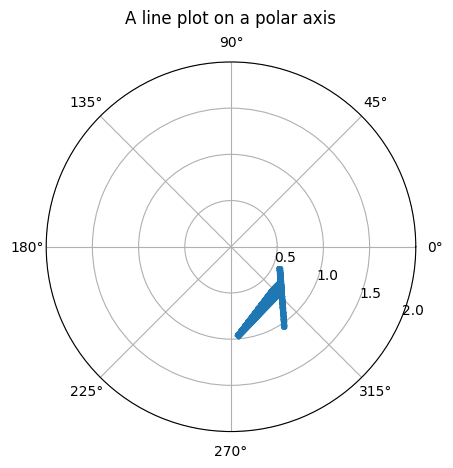

In [102]:
# Assuming 'projected_pcd' is your projected point cloud
points = np.asarray(projected_pcd.points)  # Get the points as a numpy array

# Calculate polar coordinates for each point
angles = np.arctan2(points[:, 1], points[:, 0])  # Y over X
distances = np.linalg.norm(points[:, :2], axis=1)  # Ignore Z component, calculate distance in X-Y plane

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, distances)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [105]:

def create_scan_message(angles, distances, angular_resolution_deg=1.0, angle_range=(-np.pi, np.pi)):
    angular_resolution_rad = np.deg2rad(angular_resolution_deg)
    num_intervals = int(np.ceil((angle_range[1] - angle_range[0]) / angular_resolution_rad))

    # Initialize scan data with NaNs
    scan_data = np.full(num_intervals, np.nan)

    # Convert angles to interval indices
    interval_indices = ((angles - angle_range[0]) / angular_resolution_rad).astype(int)

    # Iterate through each interval and find the closest point
    for idx in range(num_intervals):
        mask = interval_indices == idx
        if np.any(mask):
            scan_data[idx] = np.min(distances[mask])

    return scan_data

scan_data = create_scan_message(angles, distances, angular_resolution_deg=1.0, angle_range=(-np.pi, np.pi))

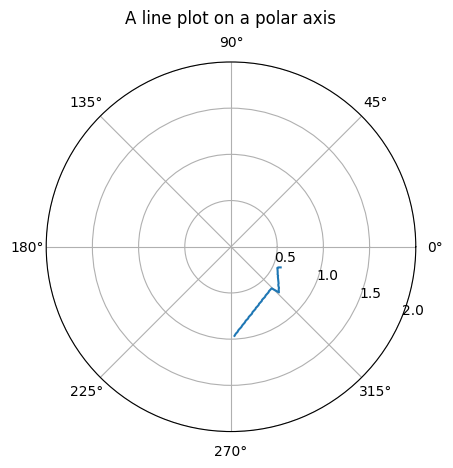

In [106]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(np.linspace(-np.pi, np.pi, len(scan_data)), scan_data)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [108]:
scan_data

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        